# Volkov Vadim
# Multi-Class classification with the perceptron on the MNIST dataset.
## In this task we need to implement the PLA algorithm to the task.
### * note that the MNIST dataset is not linearly separable so we'll implement the pocket algorithm.

### Firstly we import all the needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
start_notebook_time = time.time()
from sklearn import metrics



### Secondly we will pull the data from the MNIST dataset

In [2]:
# Load MNIST dataset
mnist = fetch_openml("mnist_784", version = 1)
# Normalize the data
X, y = mnist.data, mnist.target.astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# 1.Next we'll try to explore the data to see with what dimensions we're working with and how the data is structured

In [3]:
X.shape

(70000, 784)

In [4]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: int64

(array([6903., 7877., 6990., 7141., 6824., 6313., 6876., 7293., 6825.,
        6958.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

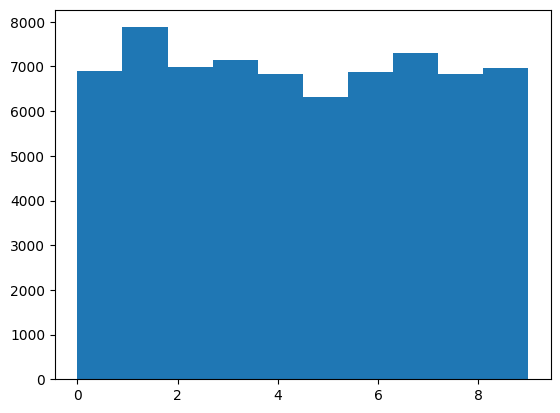

In [5]:
# see the histogram of the digit occurance
plt.hist(y)

### Observe that the digit set is distributed almost uniformly

# 2. Organization of the data

## Before splitting the data we need some preperations

### 1'. add the bias term to the features (pixels):

In [6]:
X = np.concatenate((np.ones(shape=(X.shape[0],))[:, np.newaxis], X), axis = 1)

### 2. Now splitting the pictures with the added bias term to the pixels and the 1-hot encoded predictions

In [7]:
# Split the dataset into training and testing sets
num_of_train_samples = 60000
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_of_train_samples/len(X), shuffle = True)

### 3'. 1-hot encode the predictions:

In [8]:
def encode_labels(y_set):
      num_classes = len(np.unique(y_set))
      encoded_labels = np.eye(num_classes)[y_set]
      return encoded_labels

In [9]:
y_train_1hot = encode_labels(y_train)

In [10]:
y_test_1hot = encode_labels(y_test)

# 4. Build the model

## 4.1. Implement the Multi-Class Perceptron

In [20]:
class Perceptron:

    # Init of the classes data structures and variables
    def __init__(self, X_train, Y_train, epochs):
        self.num_features = X_train.shape[1] # 785
        self.num_classes = Y_train.shape[1] # 10
        self.num_samples = X_train.shape[0] # 60000
        self.num_epochs = epochs
        # initializing the weights vector for every class with values [-1, 1] with random number with a uniform distribution
        self.weights = np.random.uniform(low=-1, high=1, size=(self.num_classes, self.num_features)) # 10x785 weight matrix with uniform distribution
        self.best_weights = np.copy(self.weights)
        self.train_loss_history= []
        self.test_loss_history = []
        self.labels= None
        self.start_time = 0
        self.end_time = 0

    # Implmentation of the Multi-Class Perceptron
    def fit(self, X_train, y_train):

        # Start timer for traning time
        self.start_time = time.time()

        print(f"Traning for {self.num_epochs} epochs")

        for epoch in range(self.num_epochs):
            # Iterating through the samples
            for sample in range(X_train.shape[0]):
                x_i = X_train[sample]
                y_i = y_train[sample]

                predicted_number = np.argmax(np.dot(x_i,self.weights.T))
                labeled_number = np.argmax(y_i)


                if predicted_number != labeled_number:
                    self.weights[predicted_number] -= x_i
                    self.weights[labeled_number] += x_i

            epoch_train_loss = self.get_loss(self.weights, X_train, y_train)
            lowest_loss = self.get_loss(self.best_weights, X_train, y_train)

            # condition of weight update + registering for loss history
            if epoch_train_loss < lowest_loss:
                self.best_weights = np.copy(self.weights)
                self.train_loss_history.append(epoch_train_loss)
            else:
                self.train_loss_history.append(lowest_loss)

            # For each epoch register the current prediction loss
            self.test_loss_history.append(1 - self.accuracy(model.predict(X_test), y_test))
        # end timer for training time
        self.end_time = time.time()
        print("done")

    # calculates the loss based on t
    def get_loss(self, weights, X_set, y_set):
        num_samples = X_set.shape[0]
        predictions = np.argmax(np.dot(X_set, weights.T), axis=1)
        num_of_missclassifiacations = np.sum(predictions != np.argmax(y_set, axis = 1))
        return num_of_missclassifiacations / num_samples

    def train_time(self):
        print(str(int(self.end_time - self.start_time)) + " Seconds")

    def predict(self, X_test):
        return np.argmax(np.dot(X_test, self.best_weights.T), axis=1)

    def accuracy(self, predictions, y_test):
        return np.sum(predictions == y_test) / len(y_test)

    # plots the multi-class confusion matrix
    def conf_matrix(self, y_test ,y_prediction):
        cm = confusion_matrix(y_test,y_prediction)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
        cm_display.plot()
        cm_display.ax_.set_title("Multi-Class Confusion Matrix")
        plt.show()

    #plots the losses of the train vs. test
    def plot_loss(self):
        plt.title('Multiclass model - train loss vs. test loss through epochs')
        plt.plot(self.train_loss_history,color = 'blue')
        plt.plot(self.test_loss_history, color = 'yellow')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def digit_stats(self, y_test, y_prediction):
        cm = confusion_matrix(y_test, y_prediction)
        #print digit stats
        for digit in range(10):

            #get stats
            TP = cm[digit][digit]
            FP = np.sum(cm[digit, :]) - TP
            FN = np.sum(cm[: ,digit]) - TP
            TN = np.sum(cm) - TP - FP - FN

            #calc metrics
            ACC = (TP+TN)/(TP+TN+FP+FN)
            TPR = TP/(TP+FN)
            TNR = TN/(TN+FP)

            #init confusion matrix and display metrics
            digit_i_cm = np.array([[TP, FP], [FN, TN]])
            digit_i_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = digit_i_cm, display_labels = [True, False])
            digit_i_cm_display.plot()
            #add title
            digit_i_cm_display.ax_.set_title(f"Class {digit} Confusion Matrix")
            #adds metrics
            digit_i_cm_display.ax_.text(-1, 2.2, f"ACC: {ACC:.3f} |")
            digit_i_cm_display.ax_.text(0, 2.2, f"TPR: {TPR:.3f} |")
            digit_i_cm_display.ax_.text(1, 2.2, f"TNR: {TNR:.3f}")
            #resizing the matrices
            digit_i_cm_display.figure_.set_figwidth(3)
            digit_i_cm_display.figure_.set_figheight(3)
            plt.show()

## 4.2.Initialize train the model with the data

In [21]:
model = Perceptron(X_train, y_train_1hot, 500)

## 4.3.Train the model

In [22]:
model.fit(X_train, y_train_1hot)

Traning for 500 epochs
done


## 4.4. Traning time duration

In [23]:
model.train_time()

504 Seconds


# 5. Evaluation of the model

### 5.1. Make prediction on the test set

In [24]:
y_prediction = model.predict(X_test)

### 5.2 Accuracy of the model's prediction

In [25]:
model.accuracy(y_prediction, y_test)

0.8975

### 5.4 Multi-Class Perceptron model train/test loss vs. epochs

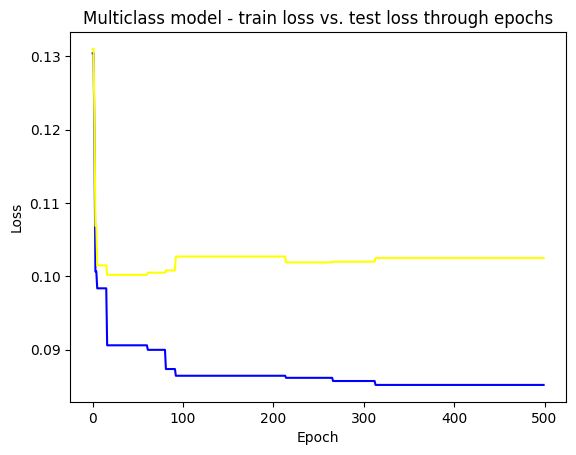

In [26]:
model.plot_loss()

### 5.3 Confusion Matrix of the Multi-Class Perceptron model

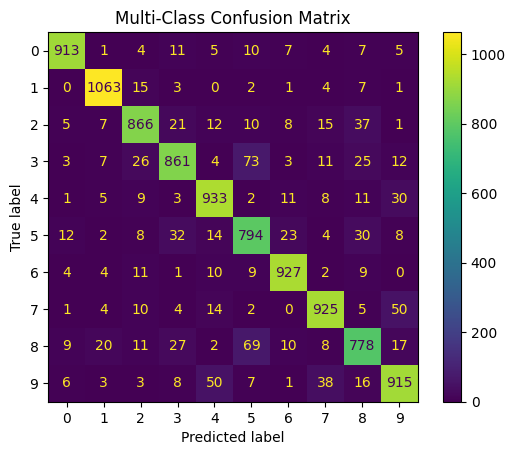

In [27]:
model.conf_matrix(y_test,y_prediction)

### 5.5 Single Digit confusion matrix and metrics

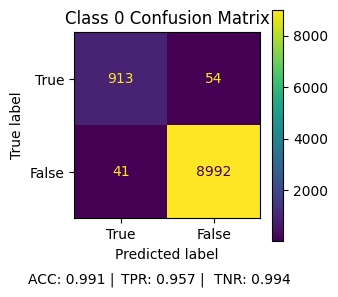

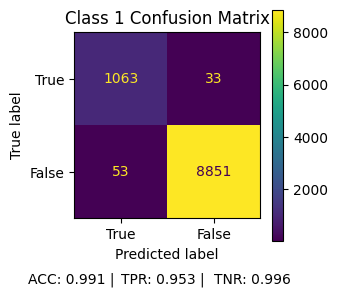

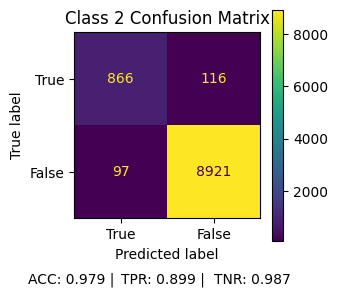

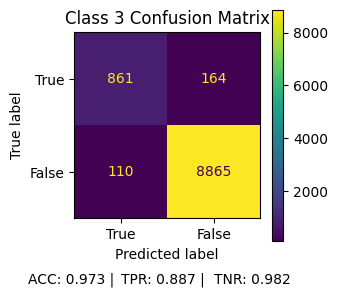

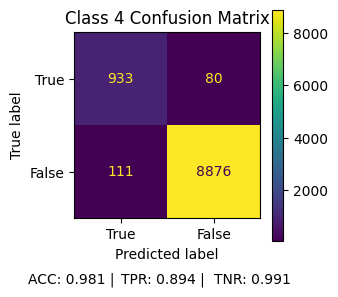

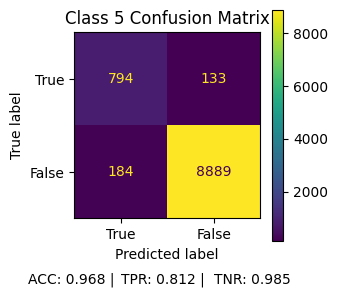

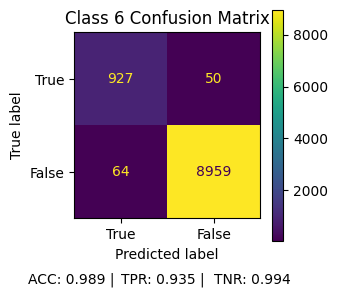

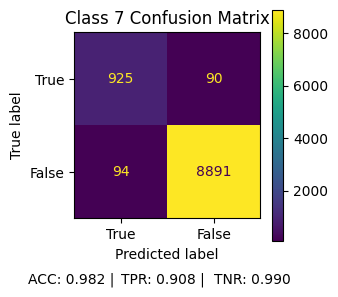

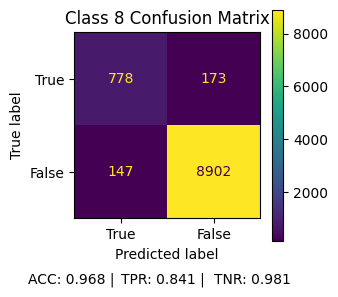

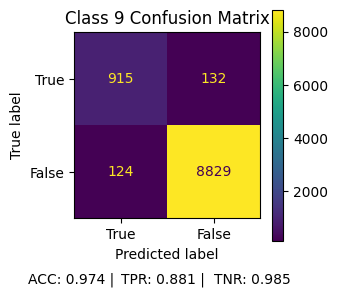

In [28]:
model.digit_stats(y_test,y_prediction)

# Conclusion and discussion

1. The Multi-Class Perceptron model predicts with an accuracy of almost 89%.    

2. From the Test vs. Train loss we can see that the convergance happens a little bit after the 35th epoch and stabilizes and after than we dont get any benefits from traning the model more than it needs.

3. Observe from the Single and Multi-Class confusion matrices that the 0,1,4,6,7 digits are more stable in terms prediction and the high TPR rating also reflects that, in contrast to their counterparts the 2,3,5,8,9 which ahve lower TPR rating, circulating arround the 0.84 mark which indicate lower prediction rate. My assumption is that more strong pixel values in the samples are affecting this scenario, because those numbers, 2,3,5,8,9, have more simillar features (painted pixels) and even for a human sometimes its had to distinguish them, moreover the model also may not be sophisticated enough to have higher accuracy.

4. From what we see from the Single digit metrics is that the TNR for each digit is very high, and our TPR is lower, which can  mean that our binary classifiers do not classify FP in large quantities, and some are classified FN more than they "should". This gives us more confidence in the classifiers for not predicting positively incorrectly, but they will predict more negatives in such matter. In terms of accuracy, the binary classifiers are also accurate.